**PREPROCESS**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN

from sklearn.preprocessing import StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv("C:/Users/srbol/OneDrive/Desktop/Binus/Semester 4/Deep learning/UAS/Nomor 1/INTC.csv", parse_dates=['Date'], index_col=['Date'])
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-03-17,0.325521,0.330729,0.325521,0.325521,0.204750,10924800
1980-03-18,0.325521,0.328125,0.322917,0.322917,0.203112,17068800
1980-03-19,0.330729,0.335938,0.330729,0.330729,0.208026,18508800
1980-03-20,0.330729,0.334635,0.329427,0.329427,0.207207,11174400
1980-03-21,0.322917,0.322917,0.317708,0.317708,0.199836,12172800


In [3]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-03-17,0.325521,0.330729,0.325521,0.325521,0.204750,10924800
1980-03-18,0.325521,0.328125,0.322917,0.322917,0.203112,17068800
1980-03-19,0.330729,0.335938,0.330729,0.330729,0.208026,18508800
1980-03-20,0.330729,0.334635,0.329427,0.329427,0.207207,11174400
1980-03-21,0.322917,0.322917,0.317708,0.317708,0.199836,12172800
...,...,...,...,...,...,...
2020-03-26,51.740002,55.950001,51.660000,55.540001,55.540001,41459800
2020-03-27,53.419998,54.639999,52.070000,52.369999,52.369999,31633500
2020-03-30,52.990002,56.099998,52.830002,55.490002,55.490002,31628600


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10098 entries, 1980-03-17 to 2020-04-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       10098 non-null  float64
 1   High       10098 non-null  float64
 2   Low        10098 non-null  float64
 3   Close      10098 non-null  float64
 4   Adj Close  10098 non-null  float64
 5   Volume     10098 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 552.2 KB


Since we're using only closing price and the date column, we can drop the others or make a new dataframe contains only date and closing price

In [5]:
df2 = pd.DataFrame(df['Close'])
df2

,Close
Date,
1980-03-17,0.325521
1980-03-18,0.322917
1980-03-19,0.330729
1980-03-20,0.329427
1980-03-21,0.317708
...,...
2020-03-26,55.540001
2020-03-27,52.369999
2020-03-30,55.490002


INTC has data record from 1980, while GOOGL only from 2024. Data length and scope can also affect the final product with the very same model. Model trained on longer historical data (INTC) may capture broader market dynamics, while those trained on shorter data GOOGL might focus on recend trends. Balancing our model so that it is suitable for multiple datasets is quite challenging

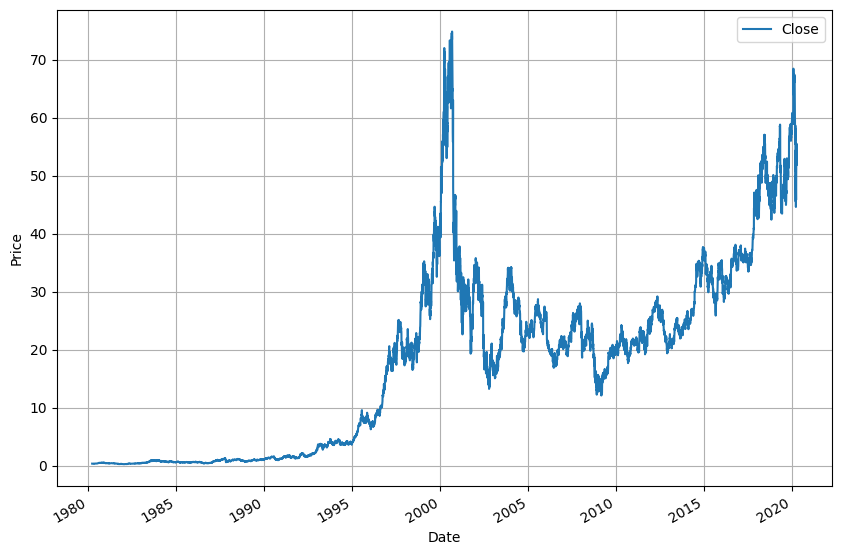

In [6]:
df2.plot(figsize=(10,7))
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)

In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10098 entries, 1980-03-17 to 2020-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   10098 non-null  float64
dtypes: float64(1)
memory usage: 157.8 KB


**DATA SPLIT**

In [8]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the data and transform it
df2 = scaler.fit_transform(df2)

# Convert the result back to a DataFrame
df2 = pd.DataFrame(df2, columns=['Price'])

In [9]:
time_step=df2.index.to_numpy()
price=df2['Price'].values.astype('float32')
time_step[:10],price[:10]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([0.001465  , 0.00143012, 0.00153476, 0.00151732, 0.00136035,
        0.00127315, 0.00129059, 0.00125571, 0.00111619, 0.00127315],
       dtype=float32))

In [10]:
train_size=int(0.8*len(price))
valid_size=int(0.1*len(price))
test_size=int(0.1*len(price))
print(train_size,valid_size,test_size)

8078 1009 1009


In [11]:
split_size_train = int(0.8 * len(price))
split_size_val = int(0.1 * len(price))

train_time, train_price = time_step[:split_size_train], price[:split_size_train]
val_time, val_price = time_step[split_size_train:split_size_train + split_size_val], price[split_size_train:split_size_train + split_size_val]
test_time, test_price = time_step[split_size_train + split_size_val:], price[split_size_train + split_size_val:]
len(train_time),len(test_time),len(train_price),len(test_price)

(8078, 1011, 8078, 1011)

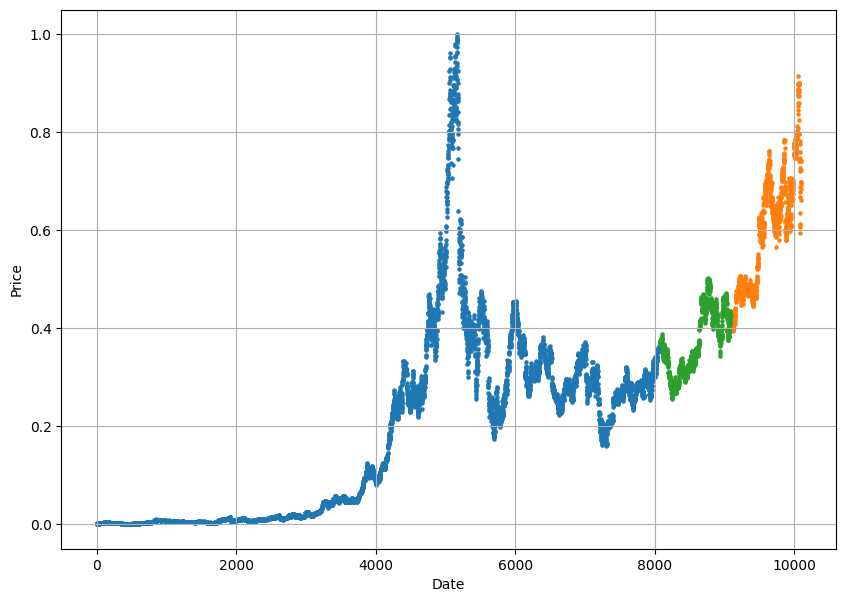

In [12]:
plt.figure(figsize=(10,7))
plt.scatter(train_time, train_price, s=5, label="Train data")
plt.scatter(test_time, test_price, s=5, label="Test data")
plt.scatter(val_time, val_price, s=5, label="val data")
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [13]:
import torch
def create_dataset(dataset, step):
    X, y = [], []
    for i in range(len(dataset)-step):
        feature = dataset[i:i+step]
        target = dataset[i+step:i+step+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

c:\Users\srbol\anaconda3\envs\deep_learning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
step = 5
X_train, y_train = create_dataset(train_price, step=step)
X_val, y_val = create_dataset(val_price, step=step)
X_test, y_test = create_dataset(test_price, step=step)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([8073, 5]) torch.Size([8073, 1])
torch.Size([1006, 5]) torch.Size([1006, 1])


C:\Users\srbol\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  if __name__ == "__main__":


For my 2nd model, i decrease LSTM layers into 5. I'd tried 48, 52, 30, and they all overfit. So tried to immediately reduce the number of layers significantly.
Also i change the Adam optimizer into RMSprop

RMSprop is favored for tasks like stock price prediction using LSTM due to its adaptive learning rate mechanism, effective handling of sparse gradients, and overall robust performance in neural network training. However, as with any optimizer choice, it's beneficial to experiment with different options and tune hyperparameters based on the specific characteristics of your dataset and model architecture.





In [15]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from keras.regularizers import l2

model = Sequential()
model.add(LSTM(units=5, activation='relu', input_shape=(5, 1))) 
model.add(Dense(units=1))
optimizer = RMSprop(learning_rate = 0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

Tried dropout before, but it made the model even worse

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5)                 140       
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.callbacks import Callback

X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=len(X_train)).batch(8)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(8)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(8)


class MetricsCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 20 == 0:
            y_pred_train = self.model.predict(X_train)
            y_pred_val = self.model.predict(X_val)
            y_pred_test = self.model.predict(X_test)

            train_rmse = np.sqrt(MeanSquaredError()(y_train, y_pred_train).numpy())
            val_rmse = np.sqrt(MeanSquaredError()(y_val, y_pred_val).numpy())
            test_rmse = np.sqrt(MeanSquaredError()(y_test, y_pred_test).numpy())

            train_mae = MeanAbsoluteError()(y_train, y_pred_train).numpy()
            val_mae = MeanAbsoluteError()(y_val, y_pred_val).numpy()
            test_mae = MeanAbsoluteError()(y_test, y_pred_test).numpy()

            train_mape = MeanAbsolutePercentageError()(y_train, y_pred_train).numpy()
            val_mape = MeanAbsolutePercentageError()(y_val, y_pred_val).numpy()
            test_mape = MeanAbsolutePercentageError()(y_test, y_pred_test).numpy()

            print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, val RMSE {val_rmse:.4f}, test RMSE {test_rmse:.4f}")
            print(f"Epoch {epoch}: train MAE {train_mae:.4f}, val MAE {val_mae:.4f}, test MAE {test_mae:.4f}")
            print(f"Epoch {epoch}: train MAPE {train_mape:.4f}, val MAPE {val_mape:.4f}, test MAPE {test_mape:.4f}")

# Melatih model
n_epochs = 10
history = model.fit(train_dataset, validation_data=val_dataset, epochs=n_epochs, callbacks=[MetricsCallback()])




Epoch 1/10
1007/1010 [============================>.] - ETA: 0s - loss: 9.5230e-04Epoch 0: train RMSE 0.0111, val RMSE 0.0093, test RMSE 0.0188
Epoch 0: train MAE 0.0058, val MAE 0.0070, test MAE 0.0128
Epoch 0: train MAPE 302.5062, val MAPE 1.8961, test MAPE 2.1062
1010/1010 [==============================] - 18s 15ms/step - loss: 9.5095e-04 - val_loss: 8.6571e-05
Epoch 2/10
1010/1010 [==============================] - 15s 15ms/step - loss: 1.2702e-04 - val_loss: 5.4928e-04
Epoch 3/10
1010/1010 [==============================] - 15s 15ms/step - loss: 1.2338e-04 - val_loss: 9.0246e-05
Epoch 4/10
1010/1010 [==============================] - 15s 14ms/step - loss: 1.2356e-04 - val_loss: 9.0120e-05
Epoch 5/10
1010/1010 [==============================] - 14s 14ms/step - loss: 1.2302e-04 - val_loss: 7.5065e-05
Epoch 6/10
1010/1010 [==============================] - 16s 16ms/step - loss: 1.1877e-04 - val_loss: 7.0415e-05
Epoch 7/10
1010/1010 [==============================] - 14s 14ms/step - 

In [18]:
y_pred_test = model.predict(X_test)

y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_test_unscaled = scaler.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()


test_rmse = np.sqrt(MeanSquaredError()(y_test_unscaled, y_pred_test_unscaled).numpy())
test_mae = MeanAbsoluteError()(y_test_unscaled, y_pred_test_unscaled).numpy()
test_mape = MeanAbsolutePercentageError()(y_test_unscaled, y_pred_test_unscaled).numpy()

print(f"Final test RMSE: {test_rmse:.4f}")
print(f"Final test MAE: {test_mae:.4f}")
print(f"Final test MAPE: {test_mape:.4f}")

Final test RMSE: 1.3847
Final test MAE: 1.0059
Final test MAPE: 2.2564


Tried to regularized the data but didn't perform better than the base pipeline, so i tried once more with simpler model 
Final test RMSE: 69.1615
Final test MAE: 61.0125
Final test MAPE: 4.9629

Also tried to change the optimizer function using RMSprop, but still can't get a better performance than the baseline

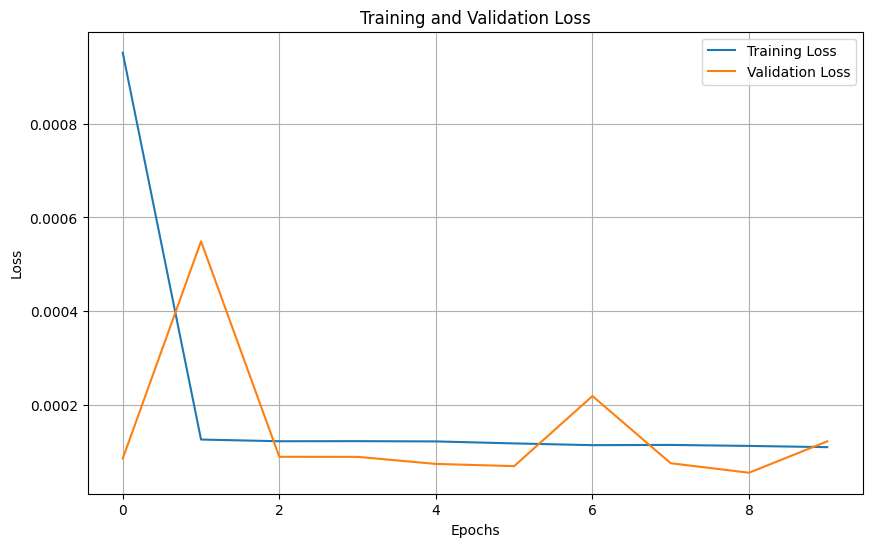

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

      Test Pred    Actual
0      0.439206  0.424382
1      0.437489  0.426793
2      0.436413  0.419694
3      0.433674  0.420765
4      0.431880  0.421301
...         ...       ...
1001   0.674537  0.741022
1002   0.704856  0.698562
1003   0.712123  0.740352
1004   0.729994  0.722002
1005   0.731738  0.691999

[1006 rows x 2 columns]


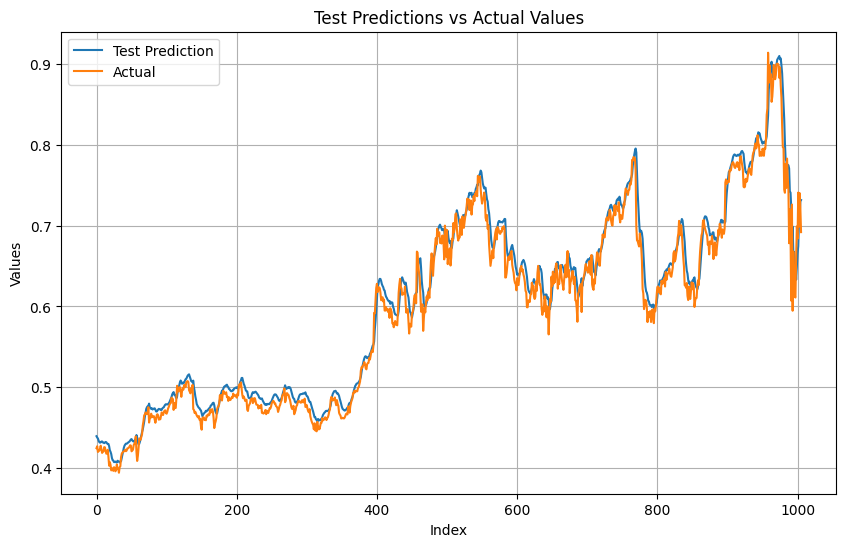

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


y_pred = model.predict(X_test)
y_pred = y_pred.flatten()
y_test = y_test.flatten()

test_res = pd.DataFrame(data={'Test Pred': y_pred, 'Actual': y_test})

print(test_res)

plt.figure(figsize=(10, 6))
plt.plot(test_res['Test Pred'], label='Test Prediction')
plt.plot(test_res['Actual'], label='Actual')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Test Predictions vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()
